In [1]:
pip install pyaudio


Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt

import pyaudio
import wave

In [3]:
# Define the parameters for audio recording
FORMAT = pyaudio.paInt16  # 16-bit resolution
RATE = 1000              # 44.1kHz sampling rate
CHUNK = 1024              # 2^10 samples per chunk
RECORD_SECONDS = 10        # Duration of recording

In [42]:
# find the index of the aux input

# Create an interface to PortAudio
audio = pyaudio.PyAudio()

# Print all available audio input devices
for i in range(audio.get_device_count()):
    device_info = audio.get_device_info_by_index(i)
    print(f"Device {i}: {device_info['name']} - Input Channels: {device_info['maxInputChannels']}")

audio.terminate()


Device 0: Microsoft Sound Mapper - Input - Input Channels: 2
Device 1: Microphone (USB Audio Device) - Input Channels: 1
Device 2: Microphone (2- Realtek(R) Audio - Input Channels: 4
Device 3: Microsoft Sound Mapper - Output - Input Channels: 0
Device 4: Speakers (USB Audio Device) - Input Channels: 0
Device 5: Speakers (2- Realtek(R) Audio) - Input Channels: 0
Device 6: Internal AUX Jack (THX Spatial) - Input Channels: 0
Device 7: Speakers (THX Spatial) - Input Channels: 0
Device 8: Primary Sound Capture Driver - Input Channels: 2
Device 9: Microphone (USB Audio Device) - Input Channels: 1
Device 10: Microphone (2- Realtek(R) Audio) - Input Channels: 4
Device 11: Primary Sound Driver - Input Channels: 0
Device 12: Speakers (USB Audio Device) - Input Channels: 0
Device 13: Speakers (2- Realtek(R) Audio) - Input Channels: 0
Device 14: Internal AUX Jack (THX Spatial) - Input Channels: 0
Device 15: Speakers (THX Spatial) - Input Channels: 0
Device 16: Speakers (USB Audio Device) - Input C

In [27]:
DEVICE_INDEX = 2
CHANNELS = 4

In [20]:
# identify/create directories
path_out = "data/recordings/temp"

if not os.path.exists(path_out):
    os.makedirs(path_out)

In [30]:
# Record audio using PyAudio

# Create an interface to PortAudio
audio = pyaudio.PyAudio()

# Open a stream with the specified parameters
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK,
                    input_device_index=DEVICE_INDEX)

print("Recording...")

frames = []

# Loop through stream and append audio chunks to frames array
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("Finished recording.")

# Stop and close the stream
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
audio.terminate()

# Save the recorded data as a WAV file
with wave.open(f"{path_out}/recording.wav", 'wb') as wf:
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(audio.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))

# Convert byte data to a NumPy array
audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)

# Normalize the audio data to the range [-1.0, 1.0]
audio_data = audio_data.astype(np.float32) / np.iinfo(np.int16).max

# save the audio data as a NumPy array
np.save(f"{path_out}/recording.npy", audio_data)


Recording...
Finished recording.


In [10]:
# # import and play .wav audio file recorded above
# import IPython.display as ipd
# ipd.Audio(f"{path_out}/recording.wav")


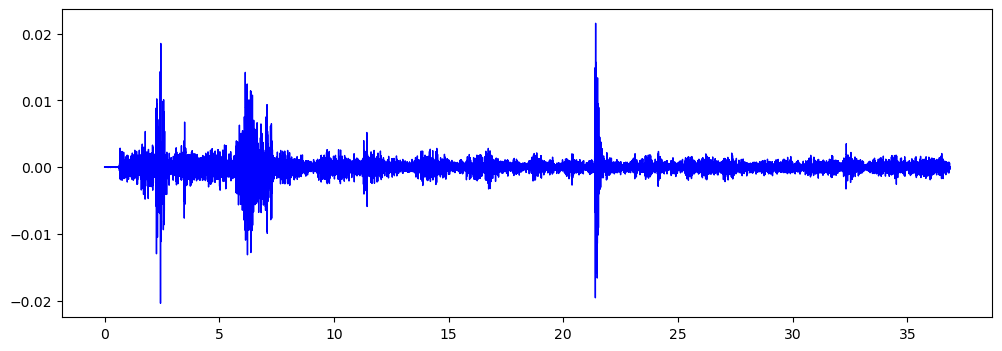

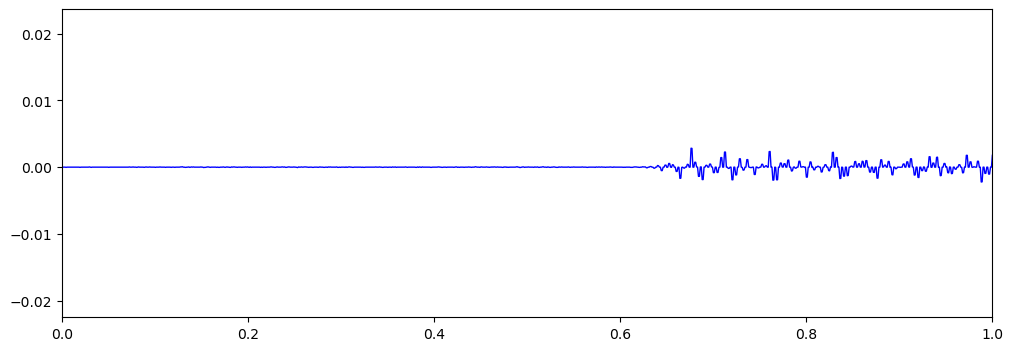

In [31]:
# plot numpy file of audio data
data = np.load(f"{path_out}/recording.npy")
time = np.linspace(0., len(data)/RATE, len(data))

fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, data, lw=1, color='b')
ax.set(xlabel="", ylabel="")
ax.set_title("")
plt.show()

fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, data, lw=1, color='b')
ax.set(xlabel="", ylabel="")
ax.set_xlim(0, 1)
plt.show()

Recording...
Finished recording.
Audio saved as data/recordings/temp/recording.wav


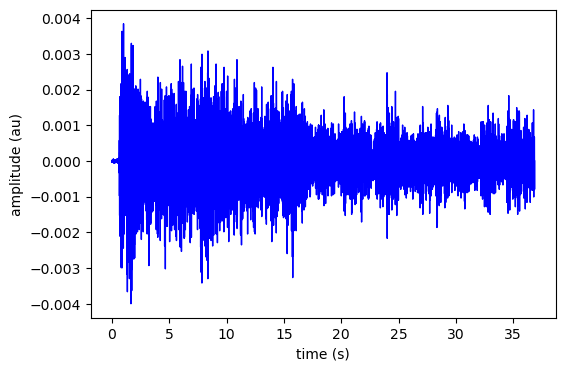

In [32]:
# here, we will record audio and save it as a .wav file to avoid memory issues

WAVE_OUTPUT_FILENAME = "data/recordings/temp/recording.wav"

# Create an interface to PortAudio
audio = pyaudio.PyAudio()

# Open a stream with the specified parameters
stream = audio.open(format=FORMAT, channels=CHANNELS,
                    rate=RATE, input=True,
                    frames_per_buffer=CHUNK,
                    input_device_index=DEVICE_INDEX)

print("Recording...")

# Open a file for writing
wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(audio.get_sample_size(FORMAT))
wf.setframerate(RATE)

# Loop through stream and write audio chunks to the file
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    wf.writeframes(data)

print("Finished recording.")

# Close the stream and the file
stream.stop_stream()
stream.close()
audio.terminate()
wf.close()

print(f"Audio saved as {WAVE_OUTPUT_FILENAME}")

# import .wav file and convert to numpy array
wf = wave.open(WAVE_OUTPUT_FILENAME, 'rb')
audio_data = wf.readframes(-1)
audio_data = np.frombuffer(audio_data, dtype=np.int16)
audio_data = audio_data.astype(np.float32) / np.iinfo(np.int16).max

# save the audio data as a NumPy array
np.save(f"{path_out}/recording.npy", audio_data)

# plot
data = np.load(f"{path_out}/recording.npy")
time = np.linspace(0., len(data)/RATE, len(data))

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.plot(time, data, lw=1, color='b')
ax.set(xlabel="time (s)", ylabel="amplitude (au)")
ax.set_title("")
plt.show()


In [39]:
def record_signal(fname, device_index, n_channels, duration, rate, chunk=1024):
    """
    Record and audio signal and save it as a .wav file.

    Parameters
    ----------
    fname : str
        File name for the .wav file.
    device_index : int
        Index of the audio input device.
    n_channels : int
        Number of audio channels associated with the device.
    duration : int
        Duration of the recording in seconds.
    rate : int
        Sampling rate of the audio signal.
    chunk : int
        Number of samples per chunk ie. the buffer size. Default is 1024.

    Returns
    -------
    None

    """

    # Create an interface to PortAudio
    audio = pyaudio.PyAudio()

    # Open a stream with the specified parameters
    stream = audio.open(format=FORMAT, channels=n_channels,
                        rate=rate, input=True,
                        frames_per_buffer=chunk,
                        input_device_index=device_index)

    print("Recording...")

    frames = []

    # Loop through stream and append audio chunks to frames array
    for i in range(0, int(rate / chunk * duration)):
        data = stream.read(chunk)
        frames.append(data)

    print("Finished recording.")

    # Stop and close the stream
    stream.stop_stream()
    stream.close()

    # Terminate the PortAudio interface
    audio.terminate()

    # Save the recorded data as a WAV file
    with wave.open(fname, 'wb') as wf:
        wf.setnchannels(n_channels)
        wf.setsampwidth(audio.get_sample_size(FORMAT))
        wf.setframerate(rate)
        wf.writeframes(b''.join(frames))

    print(f"Audio saved as {fname}")


def import_wav_to_numpy(fname, fs):
    """
    Import a .wav file and convert it to a numpy array.

    Parameters
    ----------
    fname : str
        File name of the .wav file.
    fs : int
        Sampling rate of the audio signal.

    Returns
    -------
    signal : numpy array
        Audio signal as a numpy array.
    time : numpy array
        Time vector corresponding to the audio signal.

    """

    # import .wav file and convert to numpy array
    wf = wave.open(fname, 'rb')
    audio_data = wf.readframes(-1)
    audio_data = np.frombuffer(audio_data, dtype=np.int16)
    signal = audio_data.astype(np.float32) / np.iinfo(np.int16).max

    # define time vector
    time = np.linspace(0., len(signal)/fs, len(signal))

    return signal, time


def plot_wav_file(fname, fs):
    """
    Plot the audio signal stored in a .wav file.

    Parameters
    ----------
    fname : str
        File name of the .wav file.
    fs : int
        Sampling rate of the audio signal.

    Returns
    -------
    None

    """

    # import .wav file
    signal, time = import_wav_to_numpy(fname, fs)

    # plot
    fig, ax = plt.subplots(1,1, figsize=[6,4])
    ax.plot(time, signal, lw=1, color='b')
    ax.set(xlabel="time (s)", ylabel="amplitude (au)")
    plt.show()


def plot_signal(signal, time):
    """
    Plot an audio signal.

    Parameters
    ----------
    signal : numpy array
        Audio signal as a numpy array.
    time : numpy array
        Time vector corresponding to the audio signal.

    Returns
    -------
    None

    """

    # plot
    fig, ax = plt.subplots(1,1, figsize=[6,4])
    ax.plot(time, signal, lw=1, color='b')
    ax.set(xlabel="time (s)", ylabel="amplitude (au)")
    plt.show()


def crop_signal(signal, time, start, end):
    """
    Crop an audio signal between the specified start and end times.

    Parameters
    ----------
    signal : numpy array
        Audio signal as a numpy array.
    time : numpy array
        Time vector corresponding to the audio signal.
    start : float
        Start time for cropping the signal.
    end : float
        End time for cropping the signal.

    Returns
    -------
    signal_crop : numpy array
        Cropped audio signal.
    time_crop : numpy array
        Time vector corresponding to the cropped audio signal.

    """

    # find the indices for the start and end times
    idx_start = np.where(time >= start)[0][0]
    idx_end = np.where(time >= end)[0][0]

    # crop the signal
    signal_crop = signal[idx_start:idx_end]
    time_crop = time[idx_start:idx_end]

    return signal_crop, time_crop

Recording...
Finished recording.
Audio saved as data/recordings/temp/test.wav


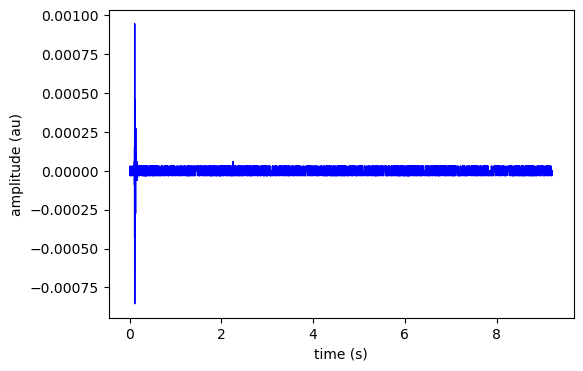

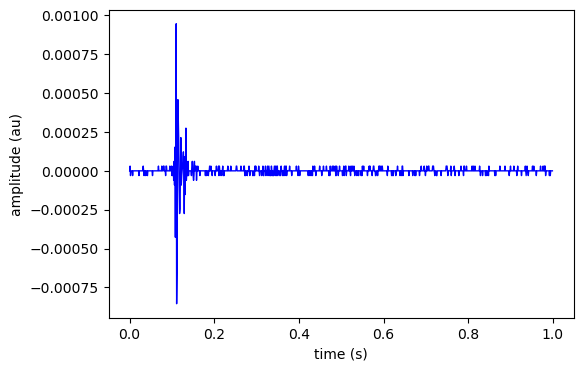

In [45]:
# test funcs
fname = "data/recordings/temp/test.wav"
rate = 1000

record_signal(fname, device_index=1, n_channels=1, duration=10, rate=rate)
signal, time = import_wav_to_numpy(fname, rate)
signal_crop, time_crop = crop_signal(signal, time, 0, 1)
plot_signal(signal, time)
plot_signal(signal_crop, time_crop)

